In [1]:
cmd <- function(bash_command) {
    output <- system(bash_command, intern=TRUE)
    last_line = ""
    
    for (line in output) { 
        cat(line)
        cat("\n")
        last_line = line 
    }
    
    return(last_line) 
}

In [2]:
cmd("pip install 'sagemaker[local]' --upgrade")

  Created wheel for sagemaker: filename=sagemaker-2.32.0-py2.py3-none-any.whl size=570899 sha256=3d653bc294f453fd52e96d33ca7b34c4889a9fb953b3725a9d61a492a049f06a
  Stored in directory: /home/ec2-user/.cache/pip/wheels/08/82/96/db3a338844388371d5f3f1a72309257f3afd5b7371f9b0b117
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.31.0
    Uninstalling sagemaker-2.31.0:
      Successfully uninstalled sagemaker-2.31.0


[1] "Successfully installed sagemaker-2.32.0"

In [3]:
s3.bucket <- "sagemaker-cookbook-bucket"
prefix <- "chapter11"

training.s3_input_location <- paste0("s3://", s3.bucket, "/", prefix ,"/input/train.r.json")
training.s3_output_location <- paste0("s3://", s3.bucket, "/", prefix ,"/output/")

In [21]:
# optionally you can do this
training.s3_input_location <- readRDS("tmp/s3.path")
training.s3_input_location

[1] "s3://sagemaker-cookbook-bucket/chapter11/input/train.r.json"

In [4]:
library('reticulate')

sagemaker <- import('sagemaker')

In [5]:
container <- "581320662326.dkr.ecr.us-east-1.amazonaws.com/r-forecast:1"

In [6]:
role <- sagemaker$get_execution_role()

In [7]:
LocalSession <- sagemaker$local$LocalSession

session <- LocalSession()
session$config <- list(local=list(local_code=TRUE))

In [8]:
TrainingInput <- sagemaker$inputs$TrainingInput

sagemaker.train_input <- TrainingInput(training.s3_input_location, content_type="application/json")

In [9]:
Estimator <- sagemaker$estimator$Estimator

estimator <- Estimator(
    container,
    role, 
    instance_count=1L, 
    instance_type="local",
    output_path=training.s3_output_location,
    sagemaker_session=session)

In [10]:
estimator$set_hyperparameters(a=1L, b=2L, c=3L)

In [11]:
estimator$fit(list(train = sagemaker.train_input))

In [12]:
estimator$model_data

[1] "s3://sagemaker-cookbook-bucket/chapter11/output/r-forecast-2021-03-30-18-18-27-242/model.tar.gz"

In [13]:
predictor <- estimator$deploy(
    initial_instance_count=1L,
    instance_type="local",
    endpoint_name="custom-local-r-forecast-endpoint"
)

In [14]:
response <- predictor$predict("100")
response

b'{"mean.values":[23.9885350121812,-30.6762091519353,90.0030153056325,-57.7124446044476,-22.2217661983072,-9.56927138971843,11.2887812821654,99.5483707368015,83.8949913932961,-17.7440402237604,214.094546895786,201.670595151679,243.190712885552,323.742116354917,176.533527993168,151.334720321892,217.947828494789,391.139490138009,432.761609586035,488.342986296729,217.151541755487,393.282393522931,218.545717029479,417.21176052879,504.92873236088,361.531462816269,378.019476703404,438.566426216005,584.202975204759,622.90524232808,639.81679209896,624.447617976731,800.412688595668,672.004456512006,838.260132030914,1097.78638633205,1154.21889553171,858.626061438434,1244.39842256527,1035.21518393473,1199.9643771023,1217.9420161629,1413.35557874676,1475.31868494884,1556.27504826391,1545.3602316701,1680.90604607505,1857.47774636901,1773.19285965541,1935.36468207853,-192.775937907358,52.6180856855357,-32.5777340318006,-14.8290893332505,48.5671441118731,-15.8678770802458,159.814432771671,-116.922957

In [15]:
library('rjson')

In [16]:
endpoint.values <- fromJSON(toString(response))
endpoint.values

$mean.values
  [1]   23.988535  -30.676209   90.003015  -57.712445  -22.221766   -9.569271
  [7]   11.288781   99.548371   83.894991  -17.744040  214.094547  201.670595
 [13]  243.190713  323.742116  176.533528  151.334720  217.947828  391.139490
 [19]  432.761610  488.342986  217.151542  393.282394  218.545717  417.211761
 [25]  504.928732  361.531463  378.019477  438.566426  584.202975  622.905242
 [31]  639.816792  624.447618  800.412689  672.004457  838.260132 1097.786386
 [37] 1154.218896  858.626061 1244.398423 1035.215184 1199.964377 1217.942016
 [43] 1413.355579 1475.318685 1556.275048 1545.360232 1680.906046 1857.477746
 [49] 1773.192860 1935.364682 -192.775938   52.618086  -32.577734  -14.829089
 [55]   48.567144  -15.867877  159.814433 -116.922958 -125.031111    9.495749
 [61]  287.886221   55.594983   87.746675  335.887328  157.087759  222.529911
 [67]  158.929651  234.377951  226.792902  334.297605  185.132454   50.357443
 [73]  197.873453  322.737850  371.459045  444.172035  344.245545  499.753855
 [79]  604.799182  507.054104  646.454828  647.731093  381.452063  932.662319
 [85]  730.649464  896.628175  818.403890 1071.864118  920.014197 1178.693266
 [91] 1264.048269 1254.376793 1418.021111 1568.553784 1511.526970 1699.166639
 [97] 1707.423187 1765.863257 1795.346717 1929.651866

$mean.start
[1] 2020  401

$mean.frequency
[1] 8760

$x.values
  [1]   23.988535  -30.676209   90.003015  -57.712445  -22.221766   -9.569271
  [7]   11.288781   99.548371   83.894991  -17.744040  214.094547  201.670595
 [13]  243.190713  323.742116  176.533528  151.334720  217.947828  391.139490
 [19]  432.761610  488.342986  217.151542  393.282394  218.545717  417.211761
 [25]  504.928732  361.531463  378.019477  438.566426  584.202975  622.905242
 [31]  639.816792  624.447618  800.412689  672.004457  838.260132 1097.786386
 [37] 1154.218896  858.626061 1244.398423 1035.215184 1199.964377 1217.942016
 [43] 1413.355579 1475.318685 1556.275048 1545.360232 1680.906046 1857.477746
 [49] 1773.192860 1935.364682 -192.775938   52.618086  -32.577734  -14.829089
 [55]   48.567144  -15.867877  159.814433 -116.922958 -125.031111    9.495749
 [61]  287.886221   55.594983   87.746675  335.887328  157.087759  222.529911
 [67]  158.929651  234.377951  226.792902  334.297605  185.132454   50.357443
 [73]  197.873453  322.737850  371.459045  444.172035  344.245545  499.753855
 [79]  604.799182  507.054104  646.454828  647.731093  381.452063  932.662319
 [85]  730.649464  896.628175  818.403890 1071.864118  920.014197 1178.693266
 [91] 1264.048269 1254.376793 1418.021111 1568.553784 1511.526970 1699.166639
 [97] 1707.423187 1765.863257 1795.346717 1929.651866  -28.485119    2.123640
[103]  -53.490828  -23.461572   -5.090547  -55.571878   56.997816  132.366156
[109]  165.676655  169.915686  251.863090  239.810345   60.764824  213.874992
[115]  392.590318   78.237856  199.675469  169.185846  347.462900  329.802991
[121]  107.816745  282.934010  459.690751  182.476466  509.634333  543.552904
[127]  409.325186  468.272417  624.884506  500.837280  541.980842  723.305340
[133]  649.377239  636.800147  668.524891  984.110571  986.091410  962.509883
[139] 1099.150418 1115.597376 1187.059947 1309.519044 1357.917639 1234.214913
[145] 1587.837278 1662.404107 1606.650119 1643.666625 1934.148827 1909.462523
[151] -169.227825   38.168181   51.600797  156.399725  -37.000807   22.229893
[157]   26.304405  228.097662  -63.213815  129.449177   19.414487  299.411507
[163]  100.284006  212.256455   81.343904  174.682102  294.859628  356.518719
[169]  440.723813  456.280633  187.274453   49.757976  245.687964  240.287976
[175]  572.034688  328.552049  375.394632  606.773614  483.779602  577.975231
[181]  734.169045  618.733769  592.115748  816.064957  970.919814  651.288065
[187]  945.555932 1129.541761 1142.721810 1136.158270 1183.952403 1233.540058
[193] 1390.302182 1402.067181 1443.354551 1566.373917 1745.197323 1570.556543
[199] 1740.377446 1899.658850    5.103607 -192.

In [17]:
library(forecast)

tmp.x <- ts(endpoint.values$x.values, 
            start=endpoint.values$x.start, 
            frequency=endpoint.values$x.frequency)

tmp.mean <- ts(endpoint.values$mean.values, 
               start=endpoint.values$mean.start, 
               frequency=endpoint.values$mean.frequency)

tmp=list(x=tmp.x, mean=tmp.mean)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



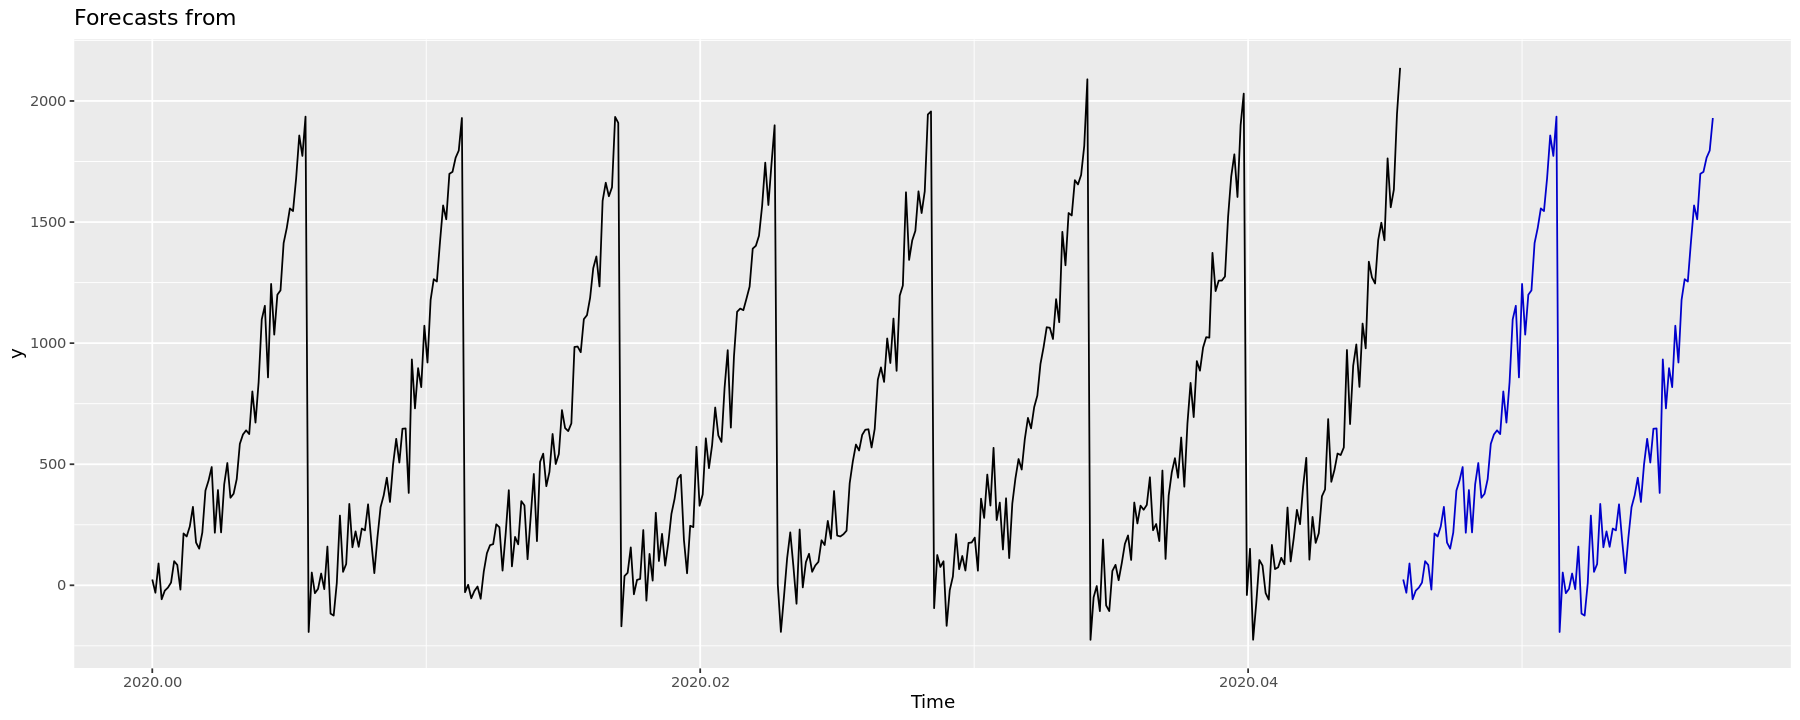

In [18]:
options(repr.plot.width=15, repr.plot.height=6)
structure(tmp, class="forecast") %>% autoplot()